# **SENTIMENT ANALYSIS**
**In this notebook, i will use dataset Sentiement-140 from [HuggingFace](https://huggingface.co/datasets/stanfordnlp/sentiment140). It contains labels data of 1.6 Million Tweets.**
# Importing Necessary Libraries

In [101]:
# Utility
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import re
from collections import Counter
import time
import pickle
import itertools

# scikit-lean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# tensoflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer

# datasets
from datasets import load_dataset

# Loading Dataset

In [5]:
twitter_data = load_dataset('sentiment140', download_mode='reuse_dataset_if_exists')

## Reading Dataset

In [50]:
train_data = twitter_data['train'].to_pandas()
test_data = twitter_data['test'].to_pandas()

In [29]:
train_data.head(10)

,text,date,user,sentiment,query
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,0,NO_QUERY
1,is upset that he can't update his Facebook by ...,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,0,NO_QUERY
2,@Kenichan I dived many times for the ball. Man...,Mon Apr 06 22:19:53 PDT 2009,mattycus,0,NO_QUERY
3,my whole body feels itchy and like its on fire,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,0,NO_QUERY
4,"@nationwideclass no, it's not behaving at all....",Mon Apr 06 22:19:57 PDT 2009,Karoli,0,NO_QUERY
5,@Kwesidei not the whole crew,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,0,NO_QUERY
6,Need a hug,Mon Apr 06 22:20:03 PDT 2009,mybirch,0,NO_QUERY
7,@LOLTrish hey long time no see! Yes.. Rains a...,Mon Apr 06 22:20:03 PDT 2009,coZZ,0,NO_QUERY
8,@Tatiana_K nope they didn't have it,Mon Apr 06 22:20:05 PDT 2009,2Hood4Hollywood,0,NO_QUERY
9,@twittera que me muera ?,Mon Apr 06 22:20:09 PDT 2009,mimismo,0,NO_QUERY


In [30]:
test_data.head(10)

,text,date,user,sentiment,query
0,@stellargirl I loooooooovvvvvveee my Kindle2. ...,Mon May 11 03:17:40 UTC 2009,tpryan,4,kindle2
1,Reading my kindle2... Love it... Lee childs i...,Mon May 11 03:18:03 UTC 2009,vcu451,4,kindle2
2,"Ok, first assesment of the #kindle2 ...it fuck...",Mon May 11 03:18:54 UTC 2009,chadfu,4,kindle2
3,@kenburbary You'll love your Kindle2. I've had...,Mon May 11 03:19:04 UTC 2009,SIX15,4,kindle2
4,@mikefish Fair enough. But i have the Kindle2...,Mon May 11 03:21:41 UTC 2009,yamarama,4,kindle2
5,@richardebaker no. it is too big. I'm quite ha...,Mon May 11 03:22:00 UTC 2009,GeorgeVHulme,4,kindle2
6,Fuck this economy. I hate aig and their non lo...,Mon May 11 03:22:30 UTC 2009,Seth937,0,aig
7,Jquery is my new best friend.,Mon May 11 03:26:10 UTC 2009,dcostalis,4,jquery
8,Loves twitter,Mon May 11 03:27:15 UTC 2009,PJ_King,4,twitter
9,how can you not love Obama? he makes jokes abo...,Mon May 11 03:29:20 UTC 2009,mandanicole,4,obama


In [31]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   text       1600000 non-null  object
 1   date       1600000 non-null  object
 2   user       1600000 non-null  object
 3   sentiment  1600000 non-null  int32 
 4   query      1600000 non-null  object
dtypes: int32(1), object(4)
memory usage: 54.9+ MB


In [32]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       498 non-null    object
 1   date       498 non-null    object
 2   user       498 non-null    object
 3   sentiment  498 non-null    int32 
 4   query      498 non-null    object
dtypes: int32(1), object(4)
memory usage: 17.6+ KB


# Dataset Preprocessing

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# EMBEDDING
SEQUENCE_LENGTH = 300

# SENTIMENT
POSITIVE = 'POSITIVE'
NEUTRAL = 'NEUTRAL'
NEGATIVE = 'NEGATIVE'

# EXPORT
MODEL_PATH = 'sentiment_analysis_model.h5'
TOKENIZER_PATH = 'tokenizer.pickle'

In [35]:
decode_map = {0: NEGATIVE, 2: NEUTRAL, 4: POSITIVE}


def decode_sentiment(label):
    return decode_map[int(label)]

In [51]:
%%time
train_data['sentiment'] = train_data['sentiment'].apply(lambda x: decode_sentiment(x))
test_data['sentiment'] = test_data['sentiment'].apply(lambda x: decode_sentiment(x))

CPU times: user 708 ms, sys: 3.99 ms, total: 712 ms
Wall time: 709 ms


In [41]:
train_data['sentiment'].value_counts()

sentiment
NEGATIVE    800000
POSITIVE    800000
Name: count, dtype: int64

In [37]:
target_cnt = Counter(train_data['sentiment'])

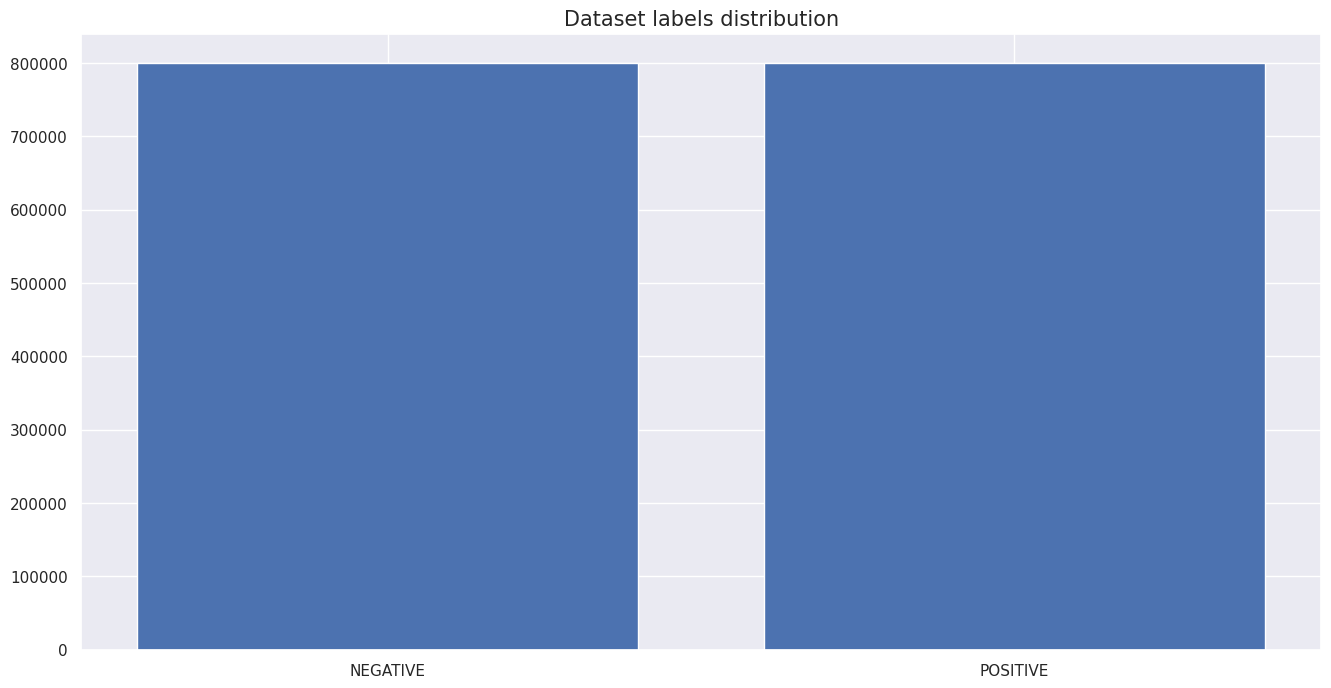

In [38]:
plt.figure(figsize=(16, 8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title('Dataset labels distribution', fontsize=15);

In [43]:
test_data['sentiment'].value_counts()

sentiment
POSITIVE    182
NEGATIVE    177
NEUTRAL     139
Name: count, dtype: int64

In [44]:
target_cnt = Counter(test_data['sentiment'])

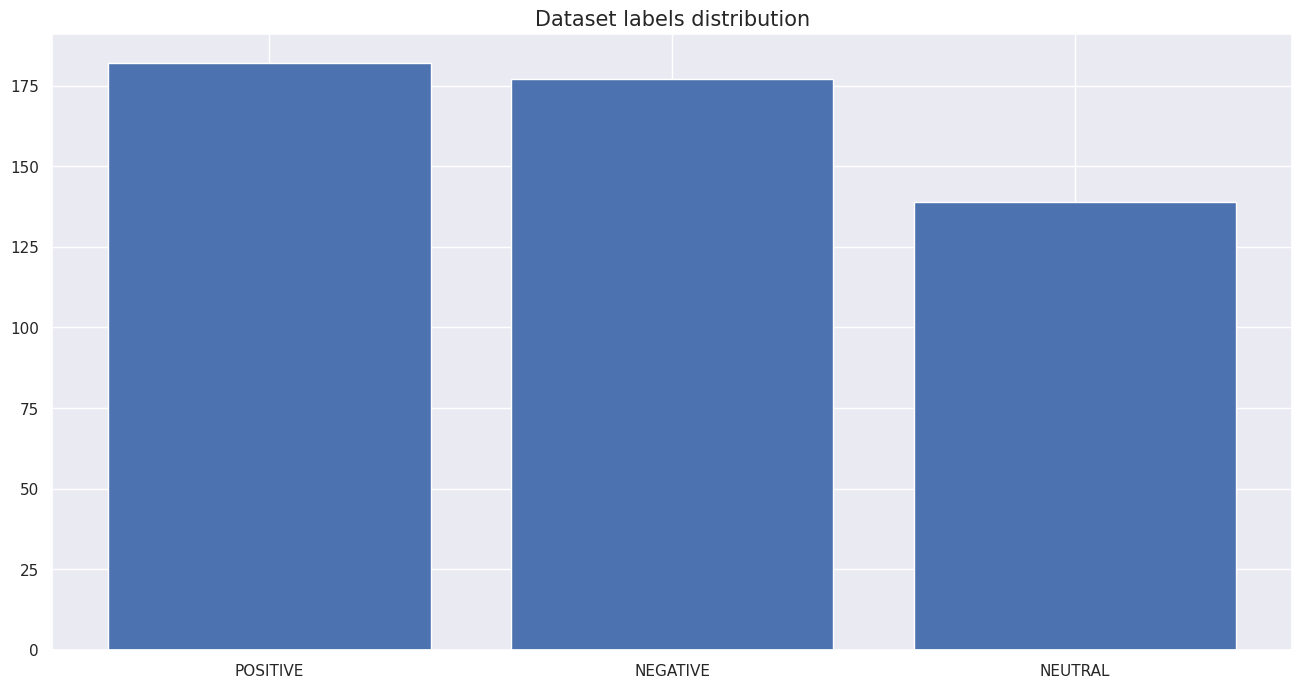

In [45]:
plt.figure(figsize=(16, 8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title('Dataset labels distribution', fontsize=15);

## Text Preprocessing
Tweet texts often consists of other user mentions, hyperlink texts, emoticons and punctuations. In order to use them for learning using a Language Model. We cannot permit those texts for training a model. So we have to clean the text data using various preprocessing and cleansing methods.

### Hyperlinks and Mentions
Twitter is a social media platform where people can tag and mentions other people's ID and share videos and blogs from internet. So the tweets often contain lots of Hyperlinks and twitter mentions.
- Twitter User Mentions - Eg. @arunrk7, @andrewng
- Hyperlinks - Eg. https://keras.io, https://tensorflow.org

### Stopwords
Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. Some stopwords are 'i', 'me', 'we', 'our',...

### NLTK is a python library which got functions to perform text processing task for NLP.

In [52]:
stop_words = stopwords.words('english')

In [55]:
def preprocess(text):
    # Remove link, user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return ' '.join(tokens)

# Train Test Split
**I will split dataset train_data into 2 datasets train and test. Then I will use dataset test_data as new data to predict and evaluate model how it works.**

In [56]:
%%time
train_data['text'] = train_data['text'].apply(lambda x: preprocess(x))
test_data['text'] = test_data['text'].apply(lambda x: preprocess(x))

CPU times: user 58.7 s, sys: 101 ms, total: 58.8 s
Wall time: 58.8 s


In [84]:
x = train_data['text']
y = train_data['sentiment']

### I will remove samples having sentiemnt NEUTRAL because i only want work with samples NEGATIVE and POSITIVE.

In [85]:
new_data = test_data[test_data['sentiment'] != NEUTRAL]

In [86]:
new_data

,text,date,user,sentiment,query
0,loooooooovvvvvveee kindle2 dx cool 2 fantastic...,Mon May 11 03:17:40 UTC 2009,tpryan,POSITIVE,kindle2
1,reading kindle2 love lee childs good read,Mon May 11 03:18:03 UTC 2009,vcu451,POSITIVE,kindle2
2,ok first assesment kindle2 fucking rocks,Mon May 11 03:18:54 UTC 2009,chadfu,POSITIVE,kindle2
3,love kindle2 mine months never looked back new...,Mon May 11 03:19:04 UTC 2009,SIX15,POSITIVE,kindle2
4,fair enough kindle2 think perfect,Mon May 11 03:21:41 UTC 2009,yamarama,POSITIVE,kindle2
...,...,...,...,...,...
492,using latex lot typeset mathematics looks hideous,Sun Jun 14 04:31:28 UTC 2009,yomcat,POSITIVE,latex
494,note hate word hate pages hate latex said hate...,Sun Jun 14 04:32:17 UTC 2009,sam33r,NEGATIVE,latex
495,ahhh back real text editing environment lt 3 l...,Sun Jun 14 04:36:34 UTC 2009,iamtheonlyjosie,POSITIVE,latex
496,trouble iran see hmm iran iran far away flocko...,Sun Jun 14 21:36:07 UTC 2009,plutopup7,NEGATIVE,iran


In [87]:
x_new = new_data['text']
y_new = new_data['sentiment']

In [88]:
labels = y.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [89]:
encoder = LabelEncoder()
y_tr = encoder.fit_transform(y.tolist())
y_tr

array([0, 0, 0, ..., 1, 1, 1])

In [90]:
y_new = encoder.transform(y_new.tolist())
y_new

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [91]:
x_train, x_test, y_train, y_test = train_test_split(x, y_tr, test_size=0.1, stratify=y_tr, random_state=42)

In [92]:
x_train

1214440    time cud meet b ur welcome 2 come c last fri f...
717515     starting feel worse cannot wait doctor appt ug...
921469                                 happy mother day mama
555412     apples new iphone 3g arrive 19th june people p...
676310        bed cpr class morning 9 2 work right til close
                                 ...                        
995754                   want called nickelback jr yes party
1038323                                            lovee boo
872372                                   new group twi tunes
502113     bought 2 chocolate bars quot 1 5 6 wins free b...
1133247    look lovely still want get reverb use wav give...
Name: text, Length: 1440000, dtype: object

In [93]:
y_train[:20]

array([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0])

In [94]:
x_test

668431     wow twitter serious people need prayer singing...
971539              beautiful bet going cook something yummy
1560003                                               thanks
1085642    thanks support everyone feel better sure fine ...
1095582    nah spam twitter saying made day better dont t...
                                 ...                        
795549            twit mylifeandart bit ly link broken tiwit
741817                                       hate cold sucks
1169789    sorry miss fab twitter identity crisis cuando ...
59737      went mates wedding last night great day evenin...
1251210    anything guys lt 3 spam street team little www...
Name: text, Length: 160000, dtype: object

In [95]:
y_test[:20]

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0])

## Tokenization
Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens , perhaps at the same time throwing away certain characters, such as punctuation. The process is called Tokenization.
- `tokenizer` create tokens for every word in the data corpus and map them to a index using dictionary.
- `word_index` contains the index for each word
- `vocab_size` represents the total number of word in the data corpus

In [96]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

CPU times: user 23.4 s, sys: 47.5 ms, total: 23.5 s
Wall time: 23.5 s


In [97]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

313597

In [98]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=SEQUENCE_LENGTH)
x_new = pad_sequences(tokenizer.texts_to_sequences(x_new), maxlen=SEQUENCE_LENGTH)

CPU times: user 29.8 s, sys: 473 ms, total: 30.2 s
Wall time: 30.2 s


In [99]:
x_train.shape, x_test.shape, x_new.shape

((1440000, 300), (160000, 300), (359, 300))

# Model Training - LSTM
**Reccurent Neural Networks can handle a seqence of data and learn a pattern of input seqence to give either sequence or scalar value as output. In our case, the Neural Network outputs a scalar value prediction.**
**For model architecture, we use**:
1. `Embedding Layer`: Generates Embedding Vector for each input sequence.
2. `Dropotranhs`: Avoids model overfit.
3. `LSTM`: Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.
4. `Dense`: Fully Connected Layers for classification.

In [102]:
model = Sequential([
    Embedding(vocab_size, 32),
    Dropout(0.5),
    LSTM(16),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [103]:
callbacks = [ReduceLROnPlateau(factor=0.5, patience=5),
             EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)]

In [104]:
%%time
history = model.fit(x_train, y_train, batch_size=256, epochs=50, validation_split=0.2, verbose=1, callbacks=callbacks)

Epoch 1/50
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 101s 21ms/step - accuracy: 0.7473 - loss: 0.5073 - val_accuracy: 0.7843 - val_loss: 0.4528 - learning_rate: 0.0010
Epoch 2/50
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 95s 21ms/step - accuracy: 0.7953 - loss: 0.4371 - val_accuracy: 0.7871 - val_loss: 0.4491 - learning_rate: 0.0010
Epoch 3/50
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 95s 21ms/step - accuracy: 0.8076 - loss: 0.4157 - val_accuracy: 0.7868 - val_loss: 0.4520 - learning_rate: 0.0010
Epoch 4/50
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 96s 21ms/step - accuracy: 0.8154 - loss: 0.4018 - val_accuracy: 0.7869 - val_loss: 0.4559 - learning_rate: 0.0010
Epoch 5/50
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 96s 21ms/step - accuracy: 0.8225 - loss: 0.3890 - val_accuracy: 0.7855 - val_loss: 0.4584 - learning_rate: 0.0010
Epoch 6/50
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 96s 21ms/step - accuracy: 0.8283 - loss: 0.3786 - val_accuracy: 0.7851 - val_loss: 0.4643 - learning_rate: 0.0010
Epoch 7/50
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 96s 21ms/step - accur

# Model Evaluation

In [106]:
%%time
score = model.evaluate(x_test, y_test, batch_size=256)
print()
print("Accuracy:",score[1])
print("Loss:",score[0])

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7864 - loss: 0.4500

Accuracy: 0.7864375114440918
Loss: 0.45130014419555664
CPU times: user 4.38 s, sys: 387 ms, total: 4.76 s
Wall time: 3.9 s


In [107]:
%%time
score = model.evaluate(x_new, y_new)
print()
print("Accuracy:",score[1])
print("Loss:",score[0])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8117 - loss: 0.3986

Accuracy: 0.8189415335655212
Loss: 0.3933941125869751
CPU times: user 143 ms, sys: 13.1 ms, total: 156 ms
Wall time: 147 ms


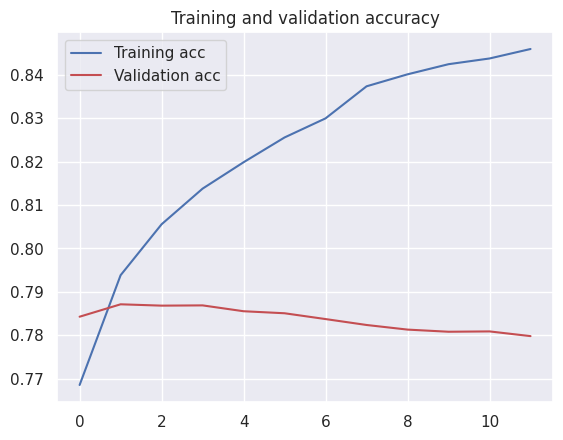

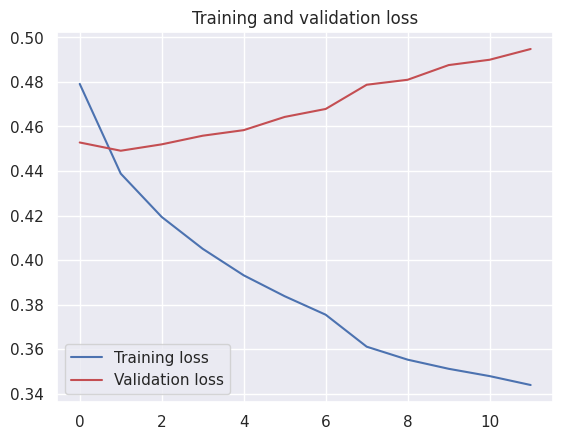

In [108]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [116]:
def decode_predict_sentiment(score, include_neutral=True):
    return 0 if score < 0.5 else 1

In [117]:
%%time
y_pred_1d = []
y_test_1d = list(y_test)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_predict_sentiment(score, include_neutral=False) for score in scores]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
CPU times: user 1.06 s, sys: 256 ms, total: 1.32 s
Wall time: 1.75 s


In [118]:
y_pred_1d[:10]

[1, 1, 1, 1, 0, 0, 1, 1, 0, 1]

In [119]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

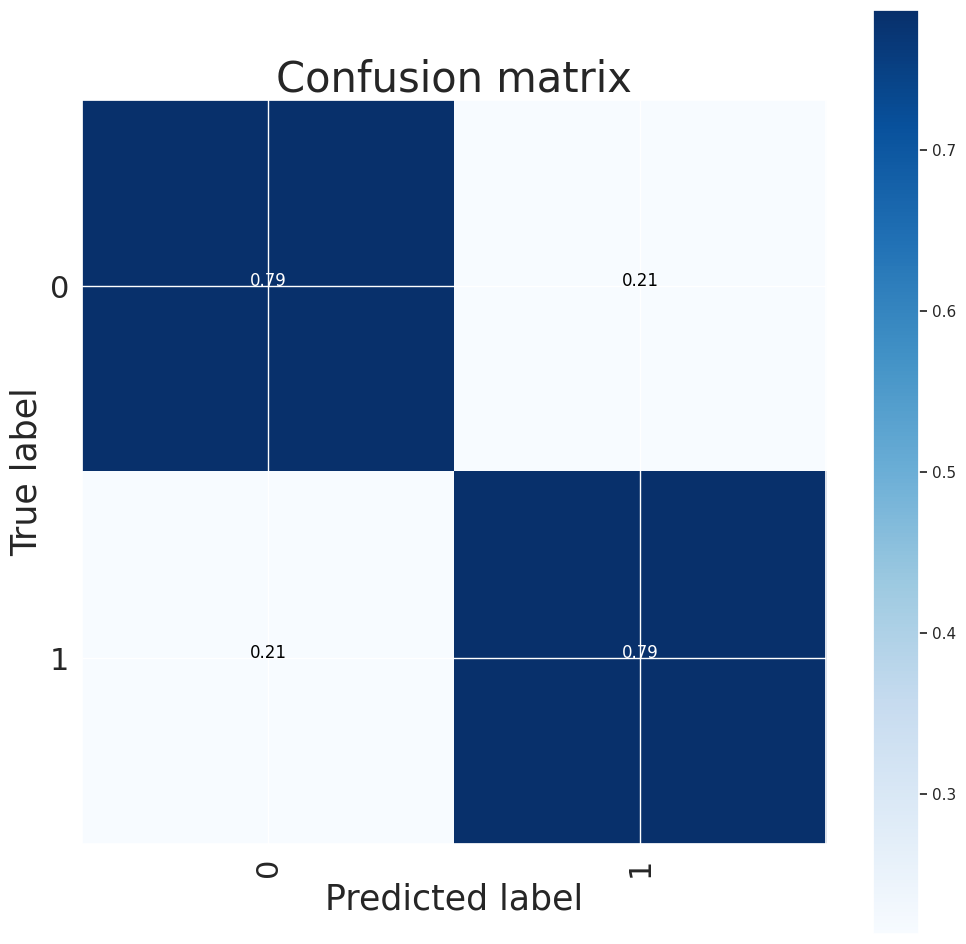

CPU times: user 504 ms, sys: 158 ms, total: 661 ms
Wall time: 391 ms


In [120]:
%%time
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_train), title="Confusion matrix")
plt.show()

## Classification Report

In [121]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79     80000
           1       0.79      0.79      0.79     80000

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



In [122]:
%%time
y_pred_1d = []
y_test_1d = list(y_new)
scores = model.predict(x_new, verbose=1, batch_size=8000)
y_pred_1d = [decode_predict_sentiment(score, include_neutral=False) for score in scores]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
CPU times: user 67.2 ms, sys: 5.02 ms, total: 72.2 ms
Wall time: 68 ms


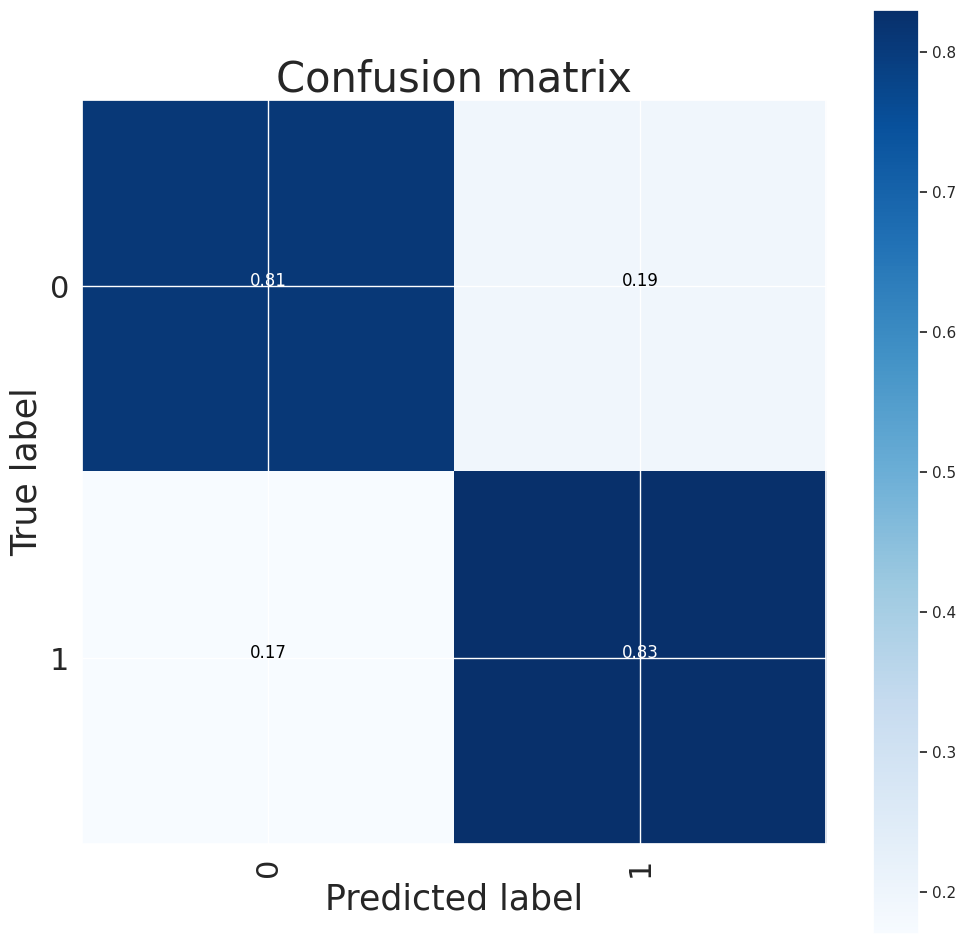

CPU times: user 422 ms, sys: 159 ms, total: 581 ms
Wall time: 310 ms


In [123]:
%%time
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_train), title="Confusion matrix")
plt.show()

In [124]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       177
           1       0.82      0.83      0.82       182

    accuracy                           0.82       359
   macro avg       0.82      0.82      0.82       359
weighted avg       0.82      0.82      0.82       359



# Save Model

In [127]:
with open(TOKENIZER_PATH, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [128]:
model.save(MODEL_PATH)